# Style Reconstruction Visualization

Author: YinTaiChen

## Packages

In [1]:
from __future__ import print_function

import numpy as np

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.models as models

import copy
import os

## Cuda

In [2]:
use_cuda = torch.cuda.is_available()
print(use_cuda)

True


In [3]:
dtype = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor
print(dtype)

<class 'torch.cuda.FloatTensor'>


## Load style image

In [4]:
imsize = 512

loader = transforms.Compose([
    transforms.RandomCrop(imsize),
    transforms.ToTensor()
])

def image_loader(image_name):
    image = Image.open(image_name)
    image = Variable(loader(image))
    image = image.unsqueeze(0)
    return image

style_img = image_loader("starry_night.jpg").type(dtype)

## Display the image

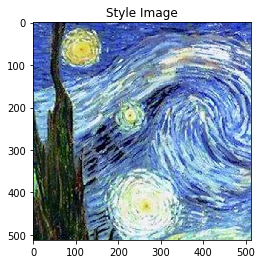

In [5]:
unloader = transforms.ToPILImage()

plt.ion()

def imshow(tensor, title=None):
    image = tensor.clone().cpu()
    image = image.view(3, imsize, imsize)
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)
    
plt.figure()
imshow(style_img.data, title="Style Image")

## Style loss

In [6]:
class GramMatrix(nn.Module):
    
    def forward(self, input):
        a, b, c, d = input.size()
        
        features = input.view(a * b, c * d)
        
        G = torch.mm(features, features.t())
        
        return G.div(a * b * c * d)

In [7]:
class StyleLoss(nn.Module):
    
    def __init__(self, target):
        super(StyleLoss, self).__init__()
        self.target = target.detach()
        self.gram = GramMatrix()
        self.criterion = nn.MSELoss()
        
    def forward(self, input):
        self.output = input.clone()
        self.G = self.gram(input)
        self.loss = self.criterion(self.G, self.target)
        return self.output
    
    def backward(self, retain_graph=True):
        self.loss.backward(retain_graph=retain_graph)
        return self.loss

## Load the neural network

In [8]:
cnn = models.vgg19(pretrained=True).features

if use_cuda:
    cnn = cnn.cuda()

In [9]:
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

def get_model_and_losses(cnn, style_img, style_layers=style_layers_default):
    cnn = copy.deepcopy(cnn)
    
    style_losses = []
    
    model = nn.Sequential()
    gram = GramMatrix()
    
    if use_cuda:
        model = model.cuda()
        gram = gram.cuda()
    
    i = 1
    for layer in list(cnn):
        if isinstance(layer, nn.Conv2d):
            name = "conv_" + str(i)
            model.add_module(name, layer)
            
            if name in style_layers:
                target_feature = model(style_img).clone()
                target_feature_gram = gram(target_feature)
                style_loss = StyleLoss(target_feature_gram)
                model.add_module("style_loss_" + str(i), style_loss)
                style_losses.append(style_loss)
                
        if isinstance(layer, nn.ReLU):
            name = "relu_" + str(i)
            model.add_module(name, layer)
            
            if name in style_layers:
                target_feature = model(style_img).clone()
                target_feature_gram = gram(target_feature)
                style_loss = StyleLoss(target_feature_gram, style_weight)
                model.add_module("style_loss_" + str(i), style_loss)
                style_losses.append(style_loss)
            
            i += 1
            
        if isinstance(layer, nn.MaxPool2d):
            name = "pool_" + str(i)
            model.add_module(name, layer)
            
    return model, style_losses

## Input image

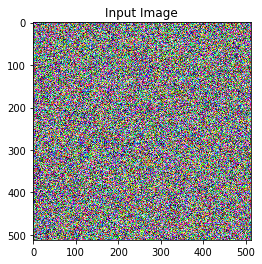

In [11]:
input_img = Variable(torch.randn(style_img.data.size())).type(dtype)

plt.figure()
imshow(input_img.data, title='Input Image')

In [12]:
print(style_img)

Variable containing:
( 0 , 0 ,.,.) = 
  0.2902  0.3686  0.3686  ...   0.1961  0.2039  0.2039
  0.3804  0.5451  0.6000  ...   0.2157  0.2275  0.2314
  0.3451  0.4863  0.6078  ...   0.2471  0.2667  0.2745
           ...             ⋱             ...          
  0.0471  0.0392  0.0471  ...   0.7059  0.7020  0.6784
  0.0627  0.0627  0.0745  ...   0.6902  0.6980  0.6784
  0.0745  0.0902  0.1020  ...   0.6706  0.6863  0.6863

( 0 , 1 ,.,.) = 
  0.4196  0.4902  0.4784  ...   0.3255  0.3333  0.3451
  0.5098  0.6667  0.7137  ...   0.3451  0.3569  0.3725
  0.4706  0.6000  0.7137  ...   0.3804  0.4000  0.4196
           ...             ⋱             ...          
  0.1137  0.0824  0.0863  ...   0.8510  0.8588  0.8314
  0.1176  0.1059  0.1137  ...   0.8353  0.8431  0.8235
  0.1294  0.1333  0.1412  ...   0.8118  0.8353  0.8353

( 0 , 2 ,.,.) = 
  0.7373  0.8118  0.8039  ...   0.6431  0.6431  0.6431
  0.8275  0.9804  1.0000  ...   0.6549  0.6588  0.6627
  0.7961  0.9137  1.0000  ...   0.6706  0.6824

In [13]:
print(input_img)

Variable containing:
( 0 , 0 ,.,.) = 
  2.2301e+00 -1.2573e+00  2.2671e+00  ...  -3.7401e-01  7.7150e-01 -1.2092e+00
 -1.9160e+00 -3.8031e-02 -1.0124e+00  ...   1.2007e-01  1.1447e+00  3.6330e-01
  1.0664e+00  6.4856e-01 -1.4449e+00  ...   8.0326e-01  1.0868e+00  6.2429e-01
                 ...                   ⋱                   ...                
  4.5471e-01 -8.0812e-01  6.9362e-01  ...  -1.3588e+00 -2.8365e-01 -1.4747e-01
 -6.7727e-01  9.6023e-01  9.9092e-01  ...   1.5626e-01  1.1632e+00  9.3423e-01
 -1.7659e-01  5.7913e-01 -1.6506e+00  ...  -1.5136e-01 -5.8123e-02  1.0105e-01

( 0 , 1 ,.,.) = 
  1.9641e-01 -4.0614e-01 -1.5369e+00  ...  -1.6862e+00 -2.2220e+00  4.4549e-01
  1.7871e+00 -7.7839e-01  1.0708e+00  ...   3.3245e-01  4.5183e-01  1.1167e+00
 -6.5792e-01 -1.1378e+00  1.0336e+00  ...   1.7949e+00 -4.8403e-01  2.9108e-01
                 ...                   ⋱                   ...                
 -9.5664e-01  3.0974e-02  1.0722e+00  ...   5.8242e-01 -1.6134e+00 -2.6603e

## Gradient descent

In [14]:
def get_input_param_optimizer(input_img):
    input_param = nn.Parameter(input_img.data)
    optimizer = optim.LBFGS([input_param])
    return input_param, optimizer

In [15]:
def run_style_reconstruction(cnn, style_img, input_img, num_steps=300):
    print('Building the content reconstruction model...')
    model, style_losses = get_model_and_losses(cnn, style_img)
    input_param, optimizer = get_input_param_optimizer(input_img)
    
    print('Optimizing...')
    
    # Create folder
    if not os.path.exists('style'):
        os.makedirs('style')
    
    run = [0]
    while run[0] <= num_steps:
        
        def closure():
            # Save modified input_img
            to_save = unloader(input_param.data.clone().cpu().view(3, 512, 512))
            to_save.save('./style/'+str(run[0])+'.jpg')
            
            input_param.data.clamp_(0, 1)
            
            optimizer.zero_grad()
            model(input_param)
            style_score = 0
            
            for sl in style_losses:
                style_score += sl.backward()
            
            run[0] += 1
            
            if run[0] % 50 == 0:
                print("run {}:".format(run))
                print('Style Loss: {:4f}'.format(style_score.data[0]))
                print()
                
            return style_score
        
        optimizer.step(closure)
        
    input_param.data.clamp_(0, 1)
    
    return input_param.data

In [16]:
output = run_style_reconstruction(cnn, style_img, input_img)

Building the content reconstruction model...
Optimizing...
run [50]:
Style Loss: 0.043103

run [100]:
Style Loss: 0.000990

run [150]:
Style Loss: 0.000007

run [200]:
Style Loss: 0.000002

run [250]:
Style Loss: 0.000001

run [300]:
Style Loss: 0.000000



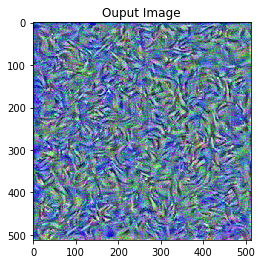

In [17]:
plt.figure()
imshow(output, title='Ouput Image')

plt.ioff()
plt.show()

## Generate GIF

In [18]:
import imageio

In [21]:
images = []
for i in range(317):
    filename = "./style/"+str(i)+".jpg"
    if i % 10 == 0:
        images.append(imageio.imread(filename))
imageio.mimsave('style_reconstruction.gif', images)